<a href="https://colab.research.google.com/github/npnayak/Credit-Card/blob/main/Final_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Approval Prediction

Our goal is to determine the ‘good’ or bad applicants. We will benchmark machine learning models on a challenging large-scale dataset to predict if an applicant is 'good' 
or 'bad' client. 

Source – Seanny - Machine Learning Group of ULB [Kaggle Link](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction)

### **In this project, we’ll be using Credit Card Approval Dataset. 
The structure of our project will be as follows:

To get a basic introduction of our project & What’s the business problem associated with it ?
We’ll start by loading and viewing the dataset.
To manipulate data, if there are any missing entries in the dataset.
To perform exploratory data analysis (EDA) on our dataset.
To pre-process data before applying machine learning model to the dataset.
To apply machine learning models that can predict if an individual’s application for a credit card will be accepted or not.

### **Credit Card Applications and the problems associated with it**

Banks receive a lot of applications for issuance of credit cards. Many of them rejected for many reasons, like high-loan balances, low-income levels, or too many inquiries on an individual’s credit report. Manually analyzing these applications is error-prone and a time-consuming process. This task can be automated with the power of machine learning, In this project, we will be build an automatic credit card approval predictor using machine learning techniques, just like the real banks do.

### **Task**

Build a machine learning model to predict if an applicant is 'good' or 'bad' client, different from other tasks, the definition of 'good' or 'bad' is not given. 

# 0. Import the necessary packages

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
!pip install scikit-plot
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.core.common import SettingWithCopyWarning
from pandas_profiling import ProfileReport
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import scikitplot as skplt

from yellowbrick.model_selection import FeatureImportances
import scipy.stats as stats
import joblib
import os
%matplotlib inline


# 1. Get the data

## 1.1 import csv file

In [120]:
# Save to df
cc_data_full_data = pd.read_csv("/content/drive/MyDrive/IS833 Team project/application_record.csv", encoding = 'utf-8')
credit_status = pd.read_csv("/content/drive/MyDrive/IS833 Team project/credit_record.csv", encoding = 'utf-8')

# Shape and preview
print('Application credit_status df shape:', cc_data_full_data.shape)
cc_data_full_data.head()

Application credit_status df shape: (438557, 18)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


## 1.2 creating the target variable

In [121]:
begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data=pd.merge(cc_data_full_data,begin_month,how='left',on='ID')
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes'
cpunt=credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
cc_data_full_data = pd.merge(cc_data_full_data,cpunt,how='inner',on='ID')
cc_data_full_data['Is high risk']=cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='Yes','Is high risk']=1
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='No','Is high risk']=0
cc_data_full_data.drop('dep_value',axis=1,inplace=True)
warnings.simplefilter(action='always', category=SettingWithCopyWarning)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A va

## 1.3 Rename features

In [122]:
# rename the features to a more readable feature names
cc_data_full_data = cc_data_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
    })

## 1.4 Split the data into training and test sets, creating a copy of the datasets

In [123]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [124]:
cc_train_original, cc_test_original = data_split(cc_data_full_data, 0.2)

In [125]:
cc_train_original.shape

(29165, 20)

In [126]:
cc_test_original.shape

(7292, 20)

In [127]:
# creating a copy of the dataset so that the original stays untouched
cc_train_copy = cc_train_original.copy()
cc_test_copy = cc_test_original.copy()

# 2. Explore the Data

## 2.1 Quick glance at the data

In [128]:
cc_data_full_data.head()

,ID,Gender,Has a car,Has a property,Children count,Income,Employment status,Education level,Marital status,Dwelling,Age,Employment length,Has a mobile phone,Has a work phone,Has a phone,Has an email,Job title,Family member count,Account age,Is high risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


In [129]:
print("Number of datapoints for application records: {}".format(len(cc_data_full_data)))
print("Number of unique clients in dataset: {}".format(len(cc_data_full_data.ID.unique())))
cc_data_full_data.head()

Number of datapoints for application records: 36457
Number of unique clients in dataset: 36457


,ID,Gender,Has a car,Has a property,Children count,Income,Employment status,Education level,Marital status,Dwelling,Age,Employment length,Has a mobile phone,Has a work phone,Has a phone,Has an email,Job title,Family member count,Account age,Is high risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


In [130]:
print("Number of datapoints for credit records: {}".format(len(credit_status)))
print("Number of unique clients in dataset: {}".format(len(credit_status.ID.unique())))
credit_status.head()

Number of datapoints for credit records: 1048575
Number of unique clients in dataset: 45985


,ID,MONTHS_BALANCE,STATUS,dep_value
0,5001711,0,X,None
1,5001711,-1,0,None
2,5001711,-2,0,None
3,5001711,-3,0,None
4,5001712,0,C,None


In [131]:
len(set(credit_status['ID']).intersection(set(cc_data_full_data['ID']))) # checking to see how many records match in two datasets

36457

In [132]:
unique_counts = pd.DataFrame.from_records([(col, cc_data_full_data[col].nunique()) for col in cc_data_full_data.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Num_Unique
12,Has a mobile phone,1
19,Is high risk,2
1,Gender,2
2,Has a car,2
3,Has a property,2
15,Has an email,2
14,Has a phone,2
13,Has a work phone,2
6,Employment status,5
7,Education level,5


In [133]:
unique_counts = pd.DataFrame.from_records([(col, credit_status[col].nunique()) for col in credit_status.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Num_Unique
3,dep_value,1
2,STATUS,8
1,MONTHS_BALANCE,61
0,ID,45985


In [134]:
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has a car            36457 non-null  object 
 3   Has a property       36457 non-null  object 
 4   Children count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment status    36457 non-null  object 
 7   Education level      36457 non-null  object 
 8   Marital status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment length    36457 non-null  int64  
 12  Has a mobile phone   36457 non-null  int64  
 13  Has a work phone     36457 non-null  int64  
 14  Has a phone          36457 non-null  int64  
 15  Has an email         36457 non-null 

In [135]:
cc_data_full_data.describe()

,ID,Children count,Income,Age,Employment length,Has a mobile phone,Has a work phone,Has a phone,Has an email,Family member count,Account age
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,-26.164193
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,16.501854
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000


In [136]:
cc_data_full_data.isna().sum()

ID                         0
Gender                     0
Has a car                  0
Has a property             0
Children count             0
Income                     0
Employment status          0
Education level            0
Marital status             0
Dwelling                   0
Age                        0
Employment length          0
Has a mobile phone         0
Has a work phone           0
Has a phone                0
Has an email               0
Job title              11323
Family member count        0
Account age                0
Is high risk               0
dtype: int64

In [137]:
credit_status.isna().sum()

ID                      0
MONTHS_BALANCE          0
STATUS                  0
dep_value         1045471
dtype: int64

In [138]:
print(f'Duplicates in cc_data_full_data df: {cc_data_full_data.iloc[:,1:].duplicated().sum()}, ({np.round(100*cc_data_full_data.iloc[:,1:].duplicated().sum()/len(cc_data_full_data),1)}%)')
print('')
print(f'Duplicates in credit_status df: {credit_status.duplicated().sum()}, ({np.round(100*credit_status.duplicated().sum()/len(credit_status),1)}%)')

Duplicates in cc_data_full_data df: 4280, (11.7%)

Duplicates in credit_status df: 0, (0.0%)


In [139]:
cc_data_full_data.nunique()

ID                     36457
Gender                     2
Has a car                  2
Has a property             2
Children count             9
Income                   265
Employment status          5
Education level            5
Marital status             5
Dwelling                   6
Age                     7183
Employment length       3640
Has a mobile phone         1
Has a work phone           2
Has a phone                2
Has an email               2
Job title                 18
Family member count       10
Account age               61
Is high risk               2
dtype: int64

In [140]:
credit_status.nunique()

ID                45985
MONTHS_BALANCE       61
STATUS                8
dep_value             1
dtype: int64

In [141]:
cc_data_full_data=cc_data_full_data.drop_duplicates(subset=cc_data_full_data.columns[1:], keep='first')

In [142]:
# Fill missing values
cc_data_full_data['Job title'].fillna(value='Other', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


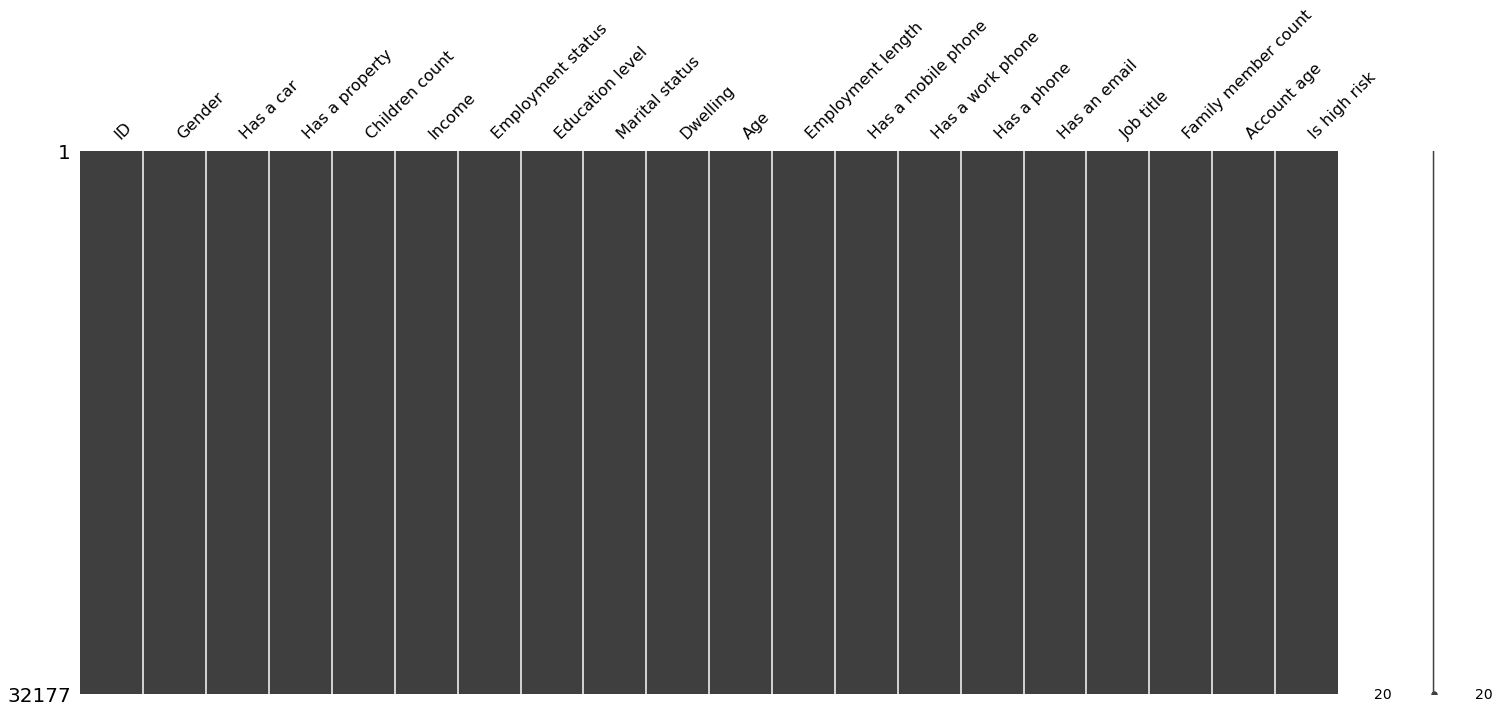

In [143]:
msno.matrix(cc_data_full_data)
plt.show()

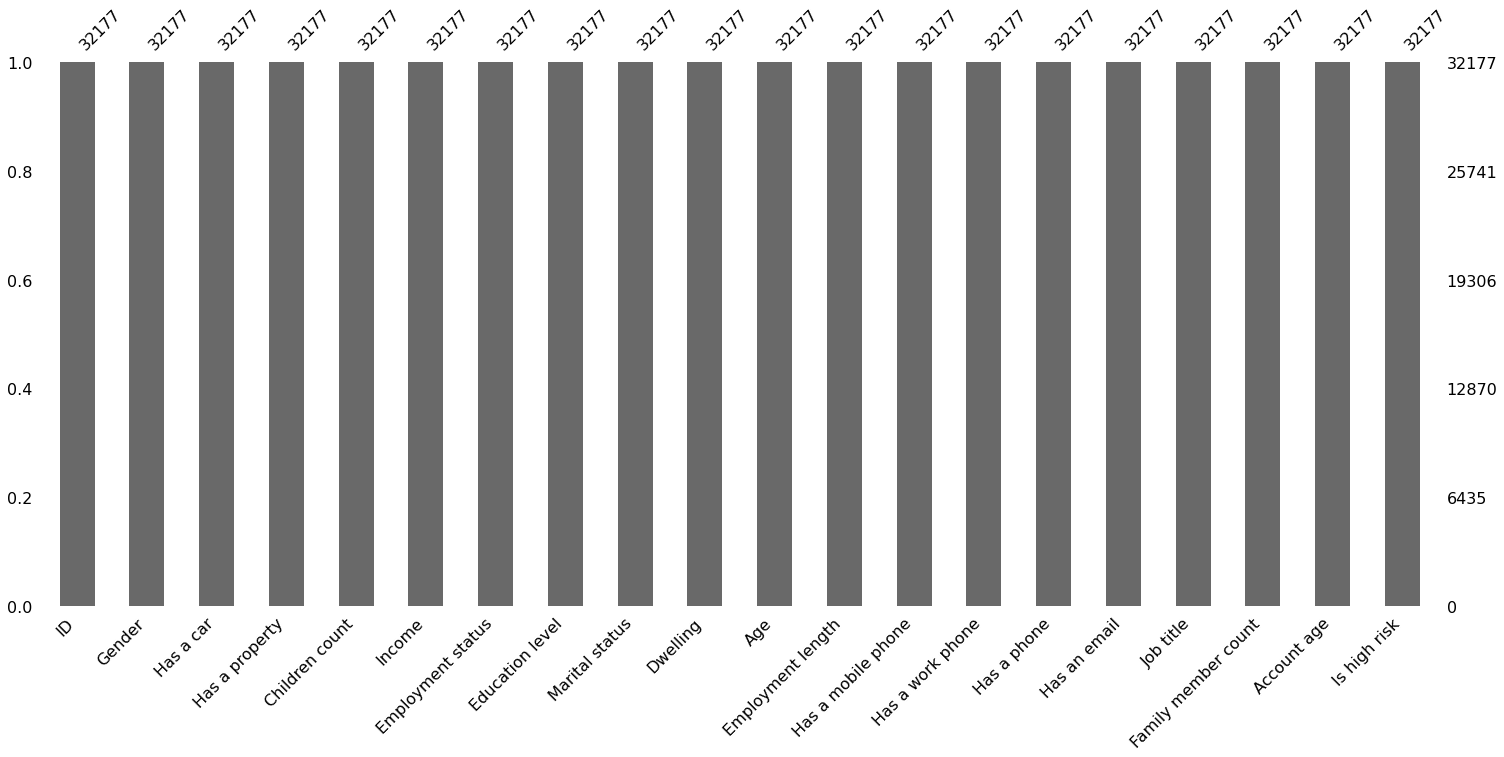

In [144]:
msno.bar(cc_data_full_data)
plt.show()

In [145]:
sns.set_context("notebook",font_scale=.7,rc={"grid.linewidth": 0.1,'patch.linewidth': 0.0,
    "axes.grid":True,
    "grid.linestyle": "-",
    "axes.titlesize" : 13,                                       
    "figure.autolayout":True})
                
palette_1 = ['#FF5E5B','#EC9B9A','#00CECB','#80DE99','#C0E680','#FFED66']

sns.set_palette(sns.color_palette(sns.color_palette(palette_1)))

<Figure size 720x720 with 0 Axes>

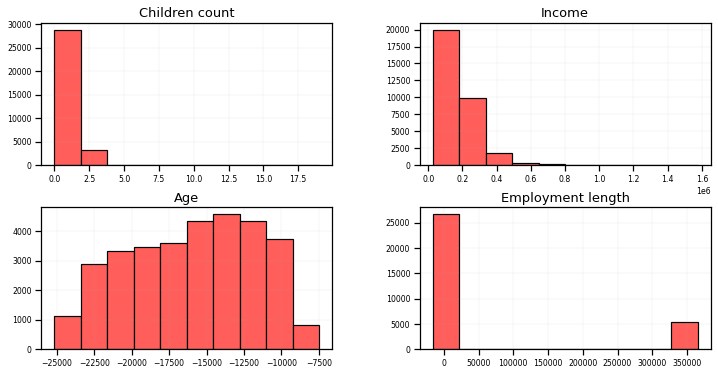

In [146]:
plt.figure(figsize=(10,10))

cols_to_plot = ["Children count","Income","Age","Employment length"]
cc_data_full_data[cols_to_plot].hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(12,6)

In [147]:
#all users account open month
open_month=pd.DataFrame(credit_status.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
open_month=open_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
customer_data=pd.merge(cc_data_full_data,open_month,how="left",on="ID") #merge to record data

#convert categoric features into numeric

customer_data["Gender"] =  customer_data['Gender'].replace(['F','M'],[0,1])
customer_data["Has a car"] = customer_data["Has a car"].replace(["Y","N"],[1,0])
customer_data["Has a property"] = customer_data["Has a property"].replace(["Y","N"],[1,0])
customer_data["Is_Working"] = customer_data["Employment status"].replace(["Working","Commercial associate","State servant","Pensioner","Student"],[1,1,1,0,0])

customer_data["In_Relationship"] = customer_data["Marital status"].replace(["Civil marriage","Married","Single / not married",
                                                                          "Separated","Widow"],[1,1,0,0,0])

housing_type = {'House / apartment' : 'House / apartment',
                   'With parents': 'With parents',
                    'Municipal apartment' : 'House / apartment',
                    'Rented apartment': 'House / apartment',
                    'Office apartment': 'House / apartment',
                    'Co-op apartment': 'House / apartment'}

customer_data["Housing_Type"] = customer_data['Dwelling'].map(housing_type)

family_status = {'Single / not married':'Single',
                     'Separated':'Single',
                     'Widow':'Single',
                     'Civil marriage':'Married',
                    'Married':'Married'}

customer_data["Family_Status"] = customer_data["Marital status"].map(family_status)

education_type = {'Secondary / secondary special':'secondary',
                     'Lower secondary':'secondary',
                     'Higher education':'Higher education',
                     'Incomplete higher':'Higher education',
                     'Academic degree':'Academic degree'}

customer_data["Education"] = customer_data["Education level"].map(education_type)

income_type = {'Commercial associate':'Working',
                  'State servant':'Working',
                  'Working':'Working',
                  'Pensioner':'Pensioner',
                  'Student':'Student'}

customer_data["Income_Type"] = customer_data["Employment status"].map(income_type)

customer_data["Household_Size"] = customer_data["Children count"] + customer_data["In_Relationship"].apply(lambda x: 2 if x==1 else 1)

customer_data["Experience"] = customer_data['Employment length']/365
customer_data['Experience']=customer_data['Employment length'].apply(lambda v : int(v*-1) if v <0 else 0)


customer_data["Age"] = round((customer_data.Age/365)*-1)

customer_data=customer_data.drop(columns=['Employment length','Age','Children count'])

customer_data= pd.get_dummies(customer_data, columns=['Income_Type', 'Education','Family_Status',"Housing_Type"])




In [148]:
def calculate_z_scores(df, cols):
    for col in cols:
        df[col+"_z_score"] = (df[col] - df[col].mean())/df[col].std()
    return df

df_2 = calculate_z_scores(df = customer_data, cols = ["Income","Experience","Household_Size"])


#removing outliers
filter_2 = df_2.Household_Size_z_score.abs() <= 3.5
filter_3 = df_2.Experience_z_score.abs() <= 3.5
filter_4 = df_2.Income_z_score.abs() <= 3.5

customer_apps = df_2[filter_2 & filter_3 & filter_4]

customer_apps.drop(columns= ["Income_z_score","Experience_z_score","Household_Size_z_score"],inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [149]:
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    
    lst = []

    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    cc_data_full_data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    cc_data_full_data['Share'] = cc_data_full_data['All'] / cc_data_full_data['All'].sum()
    cc_data_full_data['Bad Rate'] = cc_data_full_data['Bad'] / cc_data_full_data['All']
    cc_data_full_data['Distribution Good'] = (cc_data_full_data['All'] - cc_data_full_data['Bad']) / (cc_data_full_data['All'].sum() - cc_data_full_data['Bad'].sum())
    cc_data_full_data['Distribution Bad'] = cc_data_full_data['Bad'] / cc_data_full_data['Bad'].sum()
    cc_data_full_data['WoE'] = np.log(cc_data_full_data['Distribution Good'] / cc_data_full_data['Distribution Bad'])

    cc_data_full_data = cc_data_full_data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    cc_data_full_data['IV'] = cc_data_full_data['WoE'] * (cc_data_full_data['Distribution Good'] - cc_data_full_data['Distribution Bad'])

    cc_data_full_data = cc_data_full_data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    cc_data_full_data.index = range(len(cc_data_full_data.index))

    if pr:
        print(cc_data_full_data)
        print('IV = ', cc_data_full_data['IV'].sum())

    iv = cc_data_full_data['IV'].sum()

    return iv, cc_data_full_data

In [150]:
customer_data.head()

,ID,Gender,Has a car,Has a property,Income,Employment status,Education level,Marital status,Dwelling,Has a mobile phone,...,Education_Academic degree,Education_Higher education,Education_secondary,Family_Status_Married,Family_Status_Single,Housing_Type_House / apartment,Housing_Type_With parents,Income_z_score,Experience_z_score,Household_Size_z_score
0,5008804,1,1,1,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,...,0,1,0,1,0,1,0,2.399228,0.992684,-0.217748
1,5008805,1,1,1,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,...,0,1,0,1,0,1,0,2.399228,0.992684,-0.217748
2,5008806,1,1,1,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,...,0,0,1,1,0,1,0,-0.728202,-0.447055,-0.217748
3,5008808,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,...,0,0,1,0,1,1,0,0.835513,0.362798,-1.310970
4,5008809,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,...,0,0,1,0,1,1,0,0.835513,0.362798,-1.310970


In [151]:
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes' 
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes' 
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes' 
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes' 

record_count=credit_status.groupby('ID').count()
record_count['dep_value'][record_count['dep_value'] > 0]='Yes' 
record_count['dep_value'][record_count['dep_value'] == 0]='No' 
record_count = record_count[['dep_value']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

In [152]:
# Data frame to analyze length of time since initial approval of credit card
# Shows number of past dues, paid off and no loan status.
grouped = credit_status.groupby('ID')

pivot_tb = credit_status.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_tb['open_month'] = grouped['MONTHS_BALANCE'].min()
pivot_tb['end_month'] = grouped['MONTHS_BALANCE'].max()
pivot_tb['window'] = pivot_tb['end_month'] - pivot_tb['open_month']
pivot_tb['window'] += 1 # Adding 1 since month starts at 0.

#Counting number of past dues, paid offs and no loans.
pivot_tb['paid_off'] = pivot_tb[pivot_tb.iloc[:,0:61] == 'C'].count(axis = 1)
pivot_tb['pastdue_1-29'] = pivot_tb[pivot_tb.iloc[:,0:61] == '0'].count(axis = 1)
pivot_tb['pastdue_30-59'] = pivot_tb[pivot_tb.iloc[:,0:61] == '1'].count(axis = 1)
pivot_tb['pastdue_60-89'] = pivot_tb[pivot_tb.iloc[:,0:61] == '2'].count(axis = 1)
pivot_tb['pastdue_90-119'] = pivot_tb[pivot_tb.iloc[:,0:61] == '3'].count(axis = 1)
pivot_tb['pastdue_120-149'] = pivot_tb[pivot_tb.iloc[:,0:61] == '4'].count(axis = 1)
pivot_tb['pastdue_over_150'] = pivot_tb[pivot_tb.iloc[:,0:61] == '5'].count(axis = 1)
pivot_tb['no_loan'] = pivot_tb[pivot_tb.iloc[:,0:61] == 'X'].count(axis = 1)
#Setting Id column to merge with app data.
pivot_tb['ID'] = pivot_tb.index

In [153]:
pivot_tb.head()

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,...,window,paid_off,pastdue_1-29,pastdue_30-59,pastdue_60-89,pastdue_90-119,pastdue_120-149,pastdue_over_150,no_loan,ID
ID,,,,,,,,,,,,,,,,,,,,,
5001711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,0,3,0,0,0,0,0,1,5001711
5001712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19,9,10,0,0,0,0,0,0,5001712
5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22,0,0,0,0,0,0,0,22,5001713
5001714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15,0,0,0,0,0,0,0,15,5001714
5001715,NaN,X,X,X,X,X,X,X,X,X,...,60,0,0,0,0,0,0,0,60,5001715


In [154]:
target = pd.DataFrame()
target['ID'] = pivot_tb.index
target['paid_off'] = pivot_tb['paid_off'].values
target['#_of_pastdues'] = pivot_tb['pastdue_1-29'].values+ pivot_tb['pastdue_30-59'].values + pivot_tb['pastdue_60-89'].values +pivot_tb['pastdue_90-119'].values+pivot_tb['pastdue_120-149'].values +pivot_tb['pastdue_over_150'].values
target['no_loan'] = pivot_tb['no_loan'].values
customer_apps_1 = customer_apps.merge(target, how = 'inner', on = 'ID')

customer_apps_2=pd.merge(customer_apps_1,record_count,how='inner',on='ID')
customer_apps_2['target']=customer_apps_2['dep_value']
customer_apps_2.loc[customer_apps_2['target']=='Yes','target']=1
customer_apps_2.loc[customer_apps_2['target']=='No','target']=0

customer_apps_2.drop(columns=["dep_value"],inplace=True)

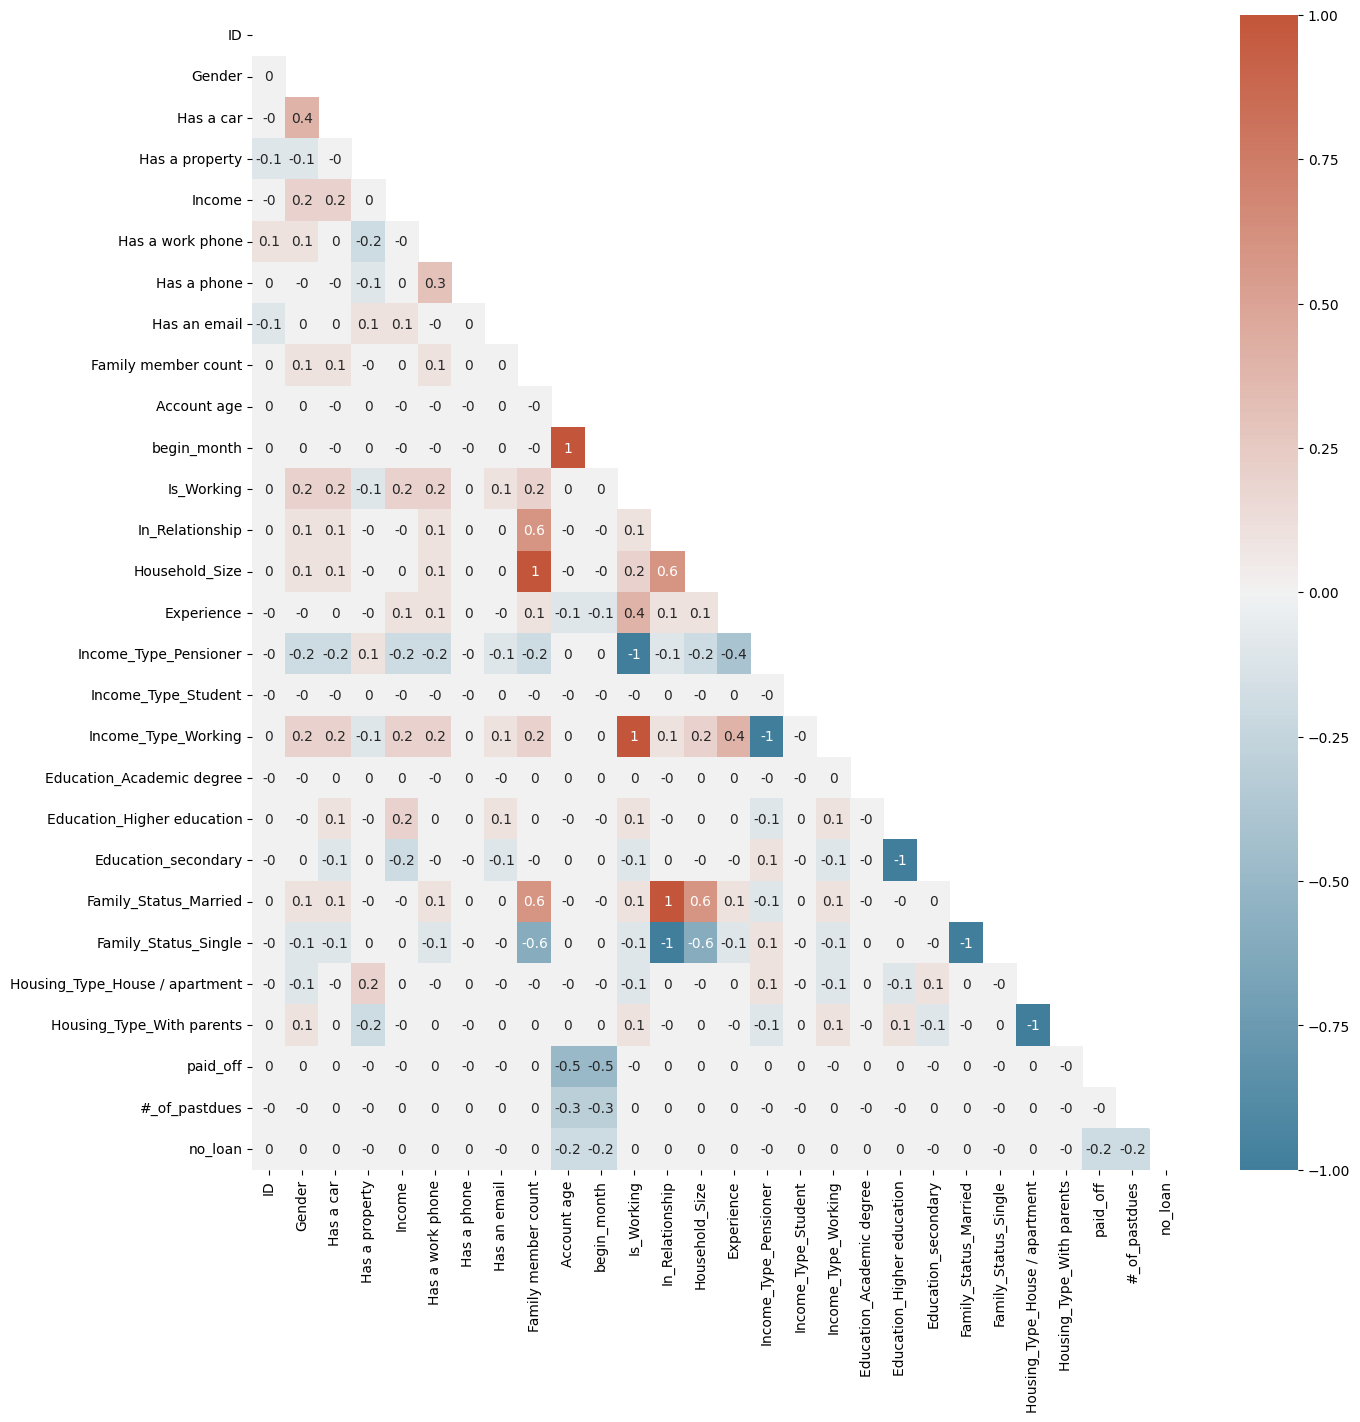

In [155]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

f, ax = plt.subplots(figsize=(15,15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr = customer_apps_2.drop(columns=['Has a mobile phone']).corr().round(1)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

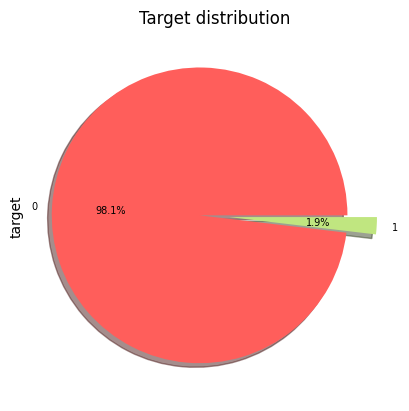

In [156]:
customer_apps_2['target'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True, colors=['#FF5E5B', '#C0E680'],textprops = {'fontsize':7}).set_title("Target distribution")

plt.show()

In [157]:
sns.set_context("notebook",font_scale=.7,rc={"grid.linewidth": 0.1,'patch.linewidth': 0.0,
    "axes.grid":True,
    "grid.linestyle": "-",
    "axes.titlesize" : 13,                                       
    'figure.figsize':(15,15)})
                
palette_1 = ['#FF5E5B','#EC9B9A','#00CECB','#80DE99','#C0E680','#FFED66']

sns.set_palette(sns.color_palette(sns.color_palette(palette_1)))

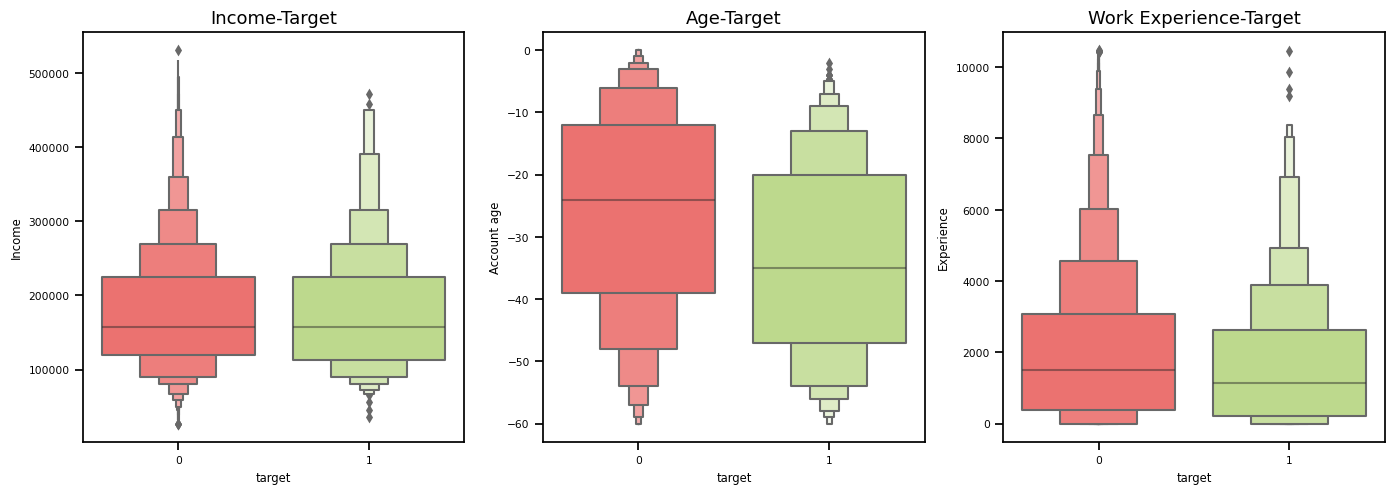

In [158]:
fig, axes = plt.subplots(1,3)

g1=sns.boxenplot(x='target', y='Income', data=customer_apps_2,palette=['#FF5E5B', '#C0E680'], ax=axes[0])
g1.set_title("Income-Target")
g2=sns.boxenplot(x='target', y='Account age', data=customer_apps_2,palette=['#FF5E5B', '#C0E680'], ax=axes[1])
g2.set_title("Age-Target")
g3=sns.boxenplot(x='target', y='Experience', data=customer_apps_2,palette=['#FF5E5B', '#C0E680'], ax=axes[2])
g3.set_title("Work Experience-Target")

fig.set_size_inches(14,5)

plt.tight_layout()

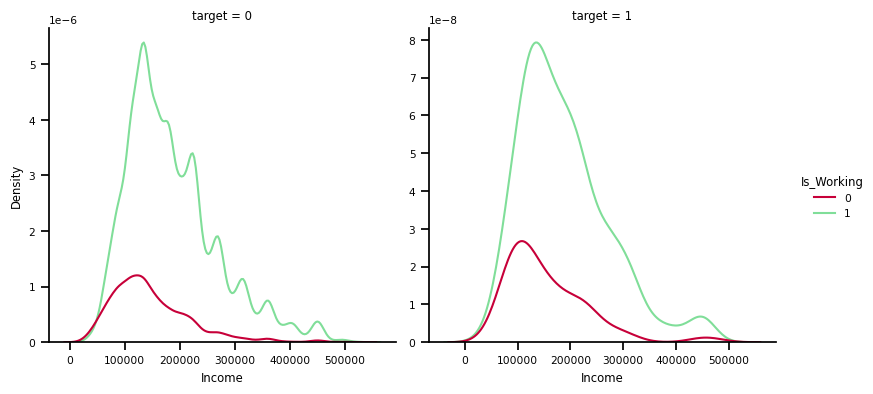

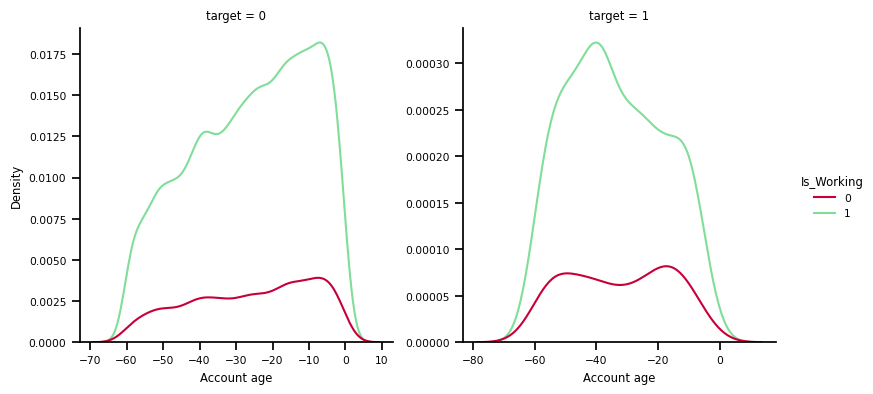

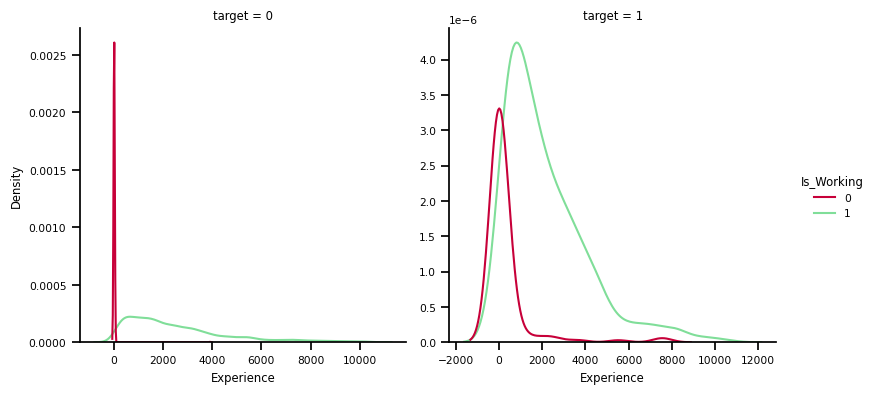

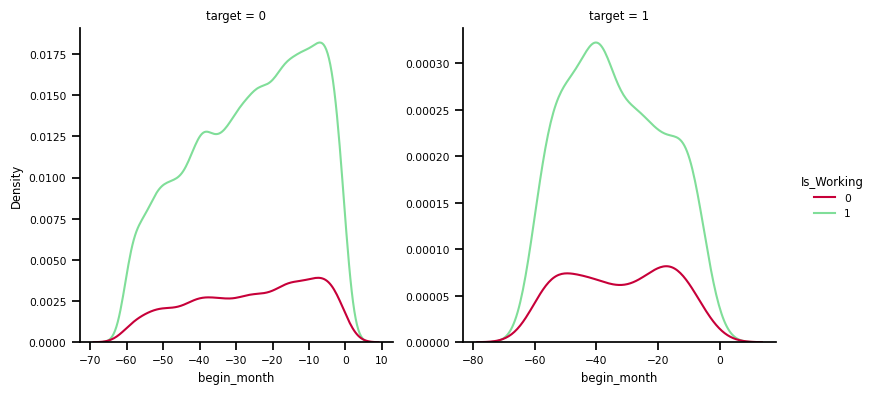

In [159]:
sns.displot(data=customer_apps_2, x='Income', hue="Is_Working", col='target', kind="kde", height=4, facet_kws={'sharey': False, 'sharex': False},palette=['#C70039','#80DE99'])
sns.displot(data=customer_apps_2, x='Account age', hue="Is_Working", col='target', kind="kde", height=4, facet_kws={'sharey': False, 'sharex': False},palette=['#C70039','#80DE99'])
sns.displot(data=customer_apps_2, x='Experience', hue="Is_Working", col='target', kind="kde", height=4, facet_kws={'sharey': False, 'sharex': False},palette=['#C70039','#80DE99'])
sns.displot(data=customer_apps_2, x='begin_month', hue="Is_Working", col='target', kind="kde", height=4, facet_kws={'sharey': False, 'sharex': False},palette=['#C70039','#80DE99'])


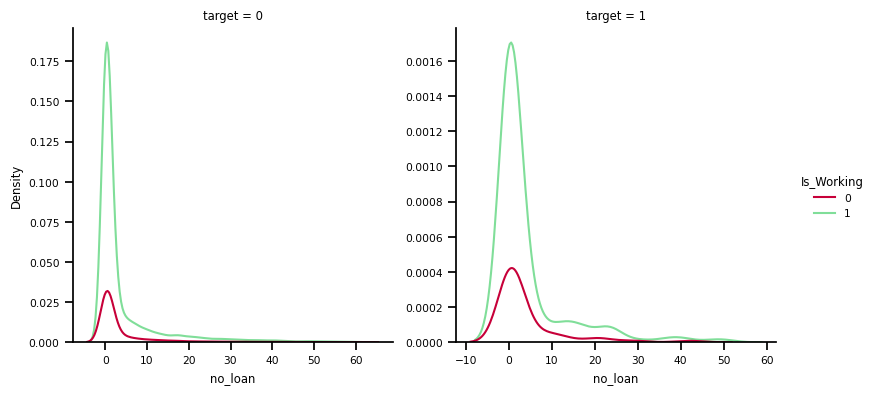

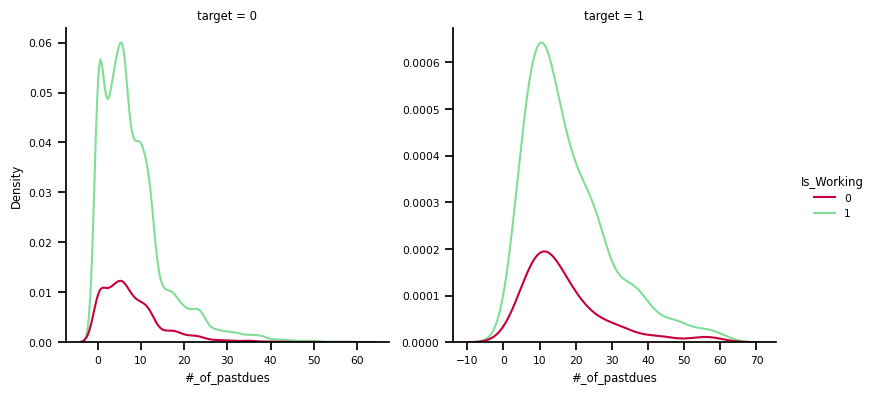

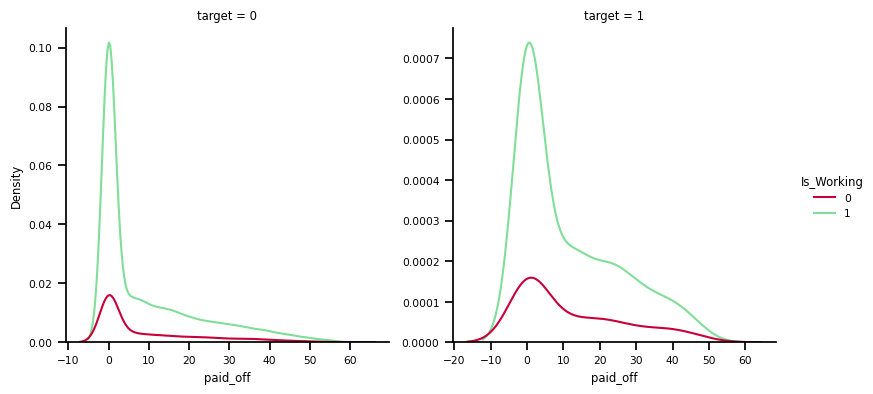

In [160]:
sns.displot(data=customer_apps_2, x='no_loan', hue="Is_Working", col='target', kind="kde", height=4, facet_kws={'sharey': False, 'sharex': False},palette=['#C70039','#80DE99'])
sns.displot(data=customer_apps_2, x='#_of_pastdues', hue="Is_Working", col='target', kind="kde", height=4, facet_kws={'sharey': False, 'sharex': False},palette=['#C70039','#80DE99'])
sns.displot(data=customer_apps_2, x='paid_off', hue="Is_Working", col='target', kind="kde", height=4, facet_kws={'sharey': False, 'sharex': False},palette=['#C70039','#80DE99'])

In [161]:
customer_apps_2.head()

,ID,Gender,Has a car,Has a property,Income,Employment status,Education level,Marital status,Dwelling,Has a mobile phone,...,Education_Higher education,Education_secondary,Family_Status_Married,Family_Status_Single,Housing_Type_House / apartment,Housing_Type_With parents,paid_off,#_of_pastdues,no_loan,target
0,5008804,1,1,1,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,...,1,0,1,0,1,0,13,2,1,0
1,5008805,1,1,1,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,...,1,0,1,0,1,0,12,2,1,0
2,5008806,1,1,1,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,...,0,1,1,0,1,0,7,7,16,0
3,5008808,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,...,0,1,0,1,1,0,0,2,3,0
4,5008809,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,...,0,1,0,1,1,0,0,0,5,0


In [162]:
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    
    lst = []

    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()

    return iv, data

In [ ]:
features = customer_apps_2.columns.tolist()[:-1]
iv_list = []
for feature in features:
    iv, data = calc_iv(customer_apps_2, feature, 'target')
    iv_list.append(round(iv,4))

woe_df = pd.DataFrame(np.column_stack([features, iv_list]), 
                      columns=['Feature', 'iv'])
woe_df

## 2.2 Functions used to explore each feature

In [ ]:
#Function that will return the value count and frequency of each observation within a feature
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [ ]:
# function to create display general information about the feature
def gen_info_feat(df,feature):
    if feature == 'Age':
        # change the feature to be express in positive numbers days
        print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
        print('*'*50)
        print('Object type:{}'.format(df[feature].dtype))
    elif feature == 'Employment length':
        # select only the rows where the rows are negative to ignore whose who have retired or unemployed
        employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
        print('*'*50)
        print('Object type:{}'.format(employment_len_no_ret.dtype))
    elif feature ==  'Account age':
        # change the account age to a positive number of months
        print('Description:\n{}'.format((np.abs(df[feature])).describe()))
        print('*'*50)
        print('Object type:{}'.format(df[feature].dtype))
    else:
        print('Description:\n{}'.format(df[feature].describe()))
        print('*'*50)
        print('Object type:\n{}'.format(df[feature].dtype))
        print('*'*50)
        value_cnt = value_cnt_norm_cal(df,feature)
        print('Value count:\n{}'.format(value_cnt))


In [ ]:
# function to create a pie chart plot
def create_pie_plot(df,feature):
    if feature ==  'Dwelling' or 'Education level':
        ratio_size = value_cnt_norm_cal(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        fig, ax = plt.subplots(figsize=(10,10))
        # %1.2f%% display decimals in the pie chart with 2 decimal places
        plt.pie(ratio_list, startangle=90, wedgeprops={'edgecolor' :'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc='best',labels=ratio_size.index)
        plt.axis('equal')
        return plt.show()
    else :
        ratio_size = value_cnt_norm_cal(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        fig, ax = plt.subplots(figsize=(10,10))
        # %1.2f%% display decimals in the pie chart with 2 decimal places
        plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc='best')
        plt.axis('equal')
        return plt.show()

In [ ]:
# function to create a bar chart plot
def create_bar_plot(df,feature):
    if feature == 'Marital status' or 'Dwelling' or 'Job title' or 'Employment status' or 'Education level':
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
        ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=45,ha='right')
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()
    else :
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()

In [ ]:
# function to create a box plot
def create_box_plot(df,feature):
    if feature == 'Age':
        fig, ax = plt.subplots(figsize=(2,8))
        # change the feature to be express in positive numbers days
        sns.boxplot(y=np.abs(df[feature])/365.25)
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    elif feature == 'Children count':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,df[feature].max(),1))
        return plt.show()
    elif feature ==  'Employment length':
        fig, ax = plt.subplots(figsize=(2,8))
        employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
        # employement length in days is a negative number so we need to change it to positive and change it to days
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        sns.boxplot(y=employment_len_no_ret_yrs)
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,employment_len_no_ret_yrs.max(),2))
        return plt.show()
    elif feature ==  'Income':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        # suppress scientific notation
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        return plt.show()
    elif feature ==  'Account age':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=np.abs(df[feature]))
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    else :
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()

In [ ]:
# function to create a histogram plot
def create_hist_plot(df,feature, the_bins=50):
    if feature == 'Age':
        fig, ax = plt.subplots(figsize=(18,10))
        # change the feature to be express in positive numbers days
        sns.histplot(np.abs(df[feature])/365.25,bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()
    elif feature == 'Income':
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(df[feature],bins=the_bins,kde=True)
        # suppress scientific notation
        ax.get_xaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.title('{} distribution'.format(feature))
        return plt.show()
    elif feature ==  'Employment length':
        employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
        # change the feature to be express in positive numbers days
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(employment_len_no_ret_yrs,bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()
    elif feature ==  'Account age':
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(np.abs(df[feature]),bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()
    else :
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(df[feature],bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()

In [ ]:
# High risk vs low risk applicants compared on a box plot
def low_high_risk_box_plot(df,feature):
    if feature == 'Age':
        print(np.abs(df.groupby('Is high risk')[feature].mean()/365.25))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(df[feature])/365.25,x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High risk individuals grouped by age')
        return plt.show()
    elif feature == 'Income':
        print(np.abs(df.groupby('Is high risk')[feature].mean()))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        # suppress scientific notation
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.title('High risk individuals grouped by {}'.format(feature))
        return plt.show()
    elif feature == 'Employment length':
        #checking is an applicant is high risk or not (for those who have negative employment length aka the employed ones)
        employment_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] <0]
        employment_no_ret_idx = employment_no_ret.index
        employment_len_no_ret_yrs = np.abs(employment_no_ret)/365.25
        employment_no_ret_df = cc_train_copy.iloc[employment_no_ret_idx][['Employment length','Is high risk']]
        employment_no_ret_is_high_risk = employment_no_ret_df.groupby('Is high risk')['Employment length'].mean()
        # compare the age of high risk individuals with the age of low risk individuals (those who are employed)
        print(np.abs(employment_no_ret_is_high_risk)/365.25)
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=employment_len_no_ret_yrs,x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High vs low risk individuals grouped by {}'.format(feature))
        return plt.show()
    else :
        print(np.abs(df.groupby('Is high risk')[feature].mean()))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High risk individuals grouped by {}'.format(feature))
        return plt.show()

In [ ]:
# High risk vs low risk applicants compared on a bar plot
def low_high_risk_bar_plot(df,feature):
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    is_high_risk_grp_srt = is_high_risk_grp.sort_values(ascending=False)
    print(dict(is_high_risk_grp_srt))
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=is_high_risk_grp_srt.index,y=is_high_risk_grp_srt.values)
    ax.set_xticklabels(labels=is_high_risk_grp_srt.index,rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title('High risk applicants count grouped by {}'.format(feature))
    return plt.show()

In [ ]:
cc_train_copy.shape

## 2.3 Univariate analysis

### 2.3.1. Gender

In [ ]:
gen_info_feat(cc_train_copy,'Gender')

In [ ]:
create_bar_plot(cc_train_copy,'Gender')

In [ ]:
create_pie_plot(cc_train_copy,'Gender')

Interpretation:
- We have more female applicants than male (67% vs 32%)

### 2.3.2 Age

In [ ]:
gen_info_feat(cc_train_copy,'Age')

In [ ]:
create_box_plot(cc_train_copy,'Age')

In [ ]:
create_hist_plot(cc_train_copy,'Age')

* bivariate analysis with target variable

In [ ]:
low_high_risk_box_plot(cc_train_copy,'Age')

Interpretation:
- The youngest applicant is 21 years old while the oldest is 68 years old. with the average of 43.7 and median of 42.6(outliers insensitive)
- Age feature is not normally distributed, it is slightly positively skew
- There is no difference between the average age of high and low risk applicants

### 2.3.3 Marital status

In [ ]:
gen_info_feat(cc_train_copy,'Marital status')

In [ ]:
create_pie_plot(cc_train_copy,'Marital status')

In [ ]:
create_bar_plot(cc_train_copy,'Marital status')

In [ ]:
low_high_risk_bar_plot(cc_train_copy,'Marital status')

Interpretation:
- Most applicants are married
- Even though we have a higher number of applicants who are separated than those who are widow, it seems like widow applicants are high risk than those who are separated.

### 2.3.4 Family member count

In [ ]:
gen_info_feat(cc_train_copy,'Family member count')

In [ ]:
create_box_plot(cc_train_copy,'Family member count')

In [ ]:
create_bar_plot(cc_train_copy,'Family member count')

Interpretation:
-   Most applicants are two in their household, this is also confirmed with the fact that most don’t have a child (more on this in a bit)
-   We also have 6 outliers, 2 of them are extreme with 20 and 15 members in their household


### 2.3.5 Children count

In [ ]:
gen_info_feat(cc_train_copy,'Children count')

In [ ]:
create_box_plot(cc_train_copy,'Children count')

In [ ]:
create_bar_plot(cc_train_copy,'Children count')

Interpretation:
-	As previously discussed most applicant don’t have a child
-	Also here we have 6 outliers, probably the same from the family member count

### 2.3.6 Dwelling type

In [ ]:
gen_info_feat(cc_train_copy,'Dwelling')

In [ ]:
create_pie_plot(cc_train_copy,'Dwelling')

In [ ]:
create_bar_plot(cc_train_copy,'Dwelling')

Interpretation:
- Almost every applicants live in house or apartment

### 2.3.7 Income

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
gen_info_feat(cc_train_copy,'Income')

In [ ]:
create_box_plot(cc_train_copy,'Income')

In [ ]:
create_hist_plot(cc_train_copy,'Income')

* bivariate analysis with target variable

In [ ]:
low_high_risk_box_plot(cc_train_copy,'Income')

Interpretation:
-	The average income is 186890 but this amount accounts for outliers. If we ignore the outlier most people make 157500
-	We have 3 applicants who makes more than 1000000
-	This feature is positively skewed
-	High risk and low risk applicants have roughly similar income

### 2.3.8 Job title

In [ ]:
gen_info_feat(cc_train_copy,'Job title')

In [ ]:
job_title_nan_count = cc_train_copy['Job title'].isna().sum()
job_title_nan_count

In [ ]:
rows_total_count = cc_train_copy.shape[0]

In [ ]:
print('The percentage of missing rows is {:.2f} %'.format(job_title_nan_count * 100 / rows_total_count))

In [ ]:
create_bar_plot(cc_train_copy,'Job title')

Interpretation:
-	The most prolific Job title is laborers by far
-	We have 30.95% if missing data

### 2.3.9 Employment status

In [ ]:
gen_info_feat(cc_train_copy,'Employment status')

In [ ]:
create_bar_plot(cc_train_copy,'Employment status')

In [ ]:
create_pie_plot(cc_train_copy,'Employment status')

Interpretation:
- Most applicants are employed

### 2.3.10 Education level

In [ ]:
gen_info_feat(cc_train_copy,'Education level')

In [ ]:
create_pie_plot(cc_train_copy,'Education level')

In [ ]:
create_bar_plot(cc_train_copy,'Education level')

Interpretation:
-	The majority of applicants have completed their secondary degree, ¼ completed their higher education

### 2.3.11 Employment length

In [ ]:
gen_info_feat(cc_train_copy,'Employment length')

In [ ]:
create_box_plot(cc_train_copy,'Employment length')

In [ ]:
create_hist_plot(cc_train_copy,'Employment length')

* bivariate analysis with target variable

In [ ]:
# distribution of employment length for high vs low risk applicants
# Here 0 means No and 1 means Yes
low_high_risk_box_plot(cc_train_copy,'Employment length')

Interpretation:
-	Most of applicant have been working for 5 years
-	We have quite a number of outliers who have been working for more than 20 years+
-	The employment length is positively skewed
-	Those who are high risk have a low employment length of 5 versus 7 years for the low risk


### 2.3.12 Has a car

In [ ]:
gen_info_feat(cc_train_copy,'Has a car')

In [ ]:
create_bar_plot(cc_train_copy,'Has a car')

In [ ]:
create_pie_plot(cc_train_copy,'Has a car')

Interpretation:
- Most applicant don’t own a car

### 2.3.13 Has a property

In [ ]:
gen_info_feat(cc_train_copy,'Has a property')

In [ ]:
create_bar_plot(cc_train_copy,'Has a property')

In [ ]:
create_pie_plot(cc_train_copy,'Has a property')

Interpretation:
- Most applicants own a property

### 2.3.14 Has a work phone

In [ ]:
gen_info_feat(cc_train_copy,'Has a work phone')

In [ ]:
create_bar_plot(cc_train_copy,'Has a work phone')

In [ ]:
create_pie_plot(cc_train_copy,'Has a work phone')

Interpretation:
- More than ¾ of applicants don’t have a work phone

Note: Here 0 is no and 1 is yes

### 2.3.15 Has a mobile phone

In [ ]:
gen_info_feat(cc_train_copy,'Has a mobile phone')

In [ ]:
create_pie_plot(cc_train_copy,'Has a mobile phone')

Interpretation:
- All the applicants without exception have a mobile phone

Note: Here 0 is no and 1 is yes

### 2.3.16 Has a phone

In [ ]:
gen_info_feat(cc_train_copy,'Has a phone')

In [ ]:
create_bar_plot(cc_train_copy,'Has a phone')

In [ ]:
create_pie_plot(cc_train_copy,'Has a phone')

Interpretation:
- Most applicants don’t have a phone (probably a home phone)

Note: Here 0 is no and 1 is yes

### 2.3.17 Has an email

In [ ]:
gen_info_feat(cc_train_copy,'Has an email')

In [ ]:
create_bar_plot(cc_train_copy,'Has an email')

In [ ]:
create_pie_plot(cc_train_copy,'Has an email')

Interpretation:
- More than 90% of applicants don’t have an email

Note: Here 0 is no and 1 is yes

### 2.3.18 Account age

In [ ]:
gen_info_feat(cc_train_copy,'Account age')

In [ ]:
create_box_plot(cc_train_copy,'Account age')

In [ ]:
create_hist_plot(cc_train_copy,'Account age', the_bins=30)

* bivariate analysis with target variable

In [ ]:
low_high_risk_box_plot(cc_train_copy,'Account age')

Interpretation:
-	Most accounts are 26 months old
-	Account age is not normally distributed, it is positively skewed
-	The accounts that have been flagged as high risk are on average 34 months old vs 26 months old for old account

### 2.3.19 Is high risk (target variable)

In [ ]:
gen_info_feat(cc_train_copy,'Is high risk')

In [ ]:
create_bar_plot(cc_train_copy,'Is high risk')

In [ ]:
create_pie_plot(cc_train_copy,'Is high risk')

Interpretation:
- A vast majority of applicants are low risk applicants.
- We have a very imbalance data.

Note: Here 0 is no and 1 is yes


## 2.4 Bivariate analysis

### 2.4.1 Numerical vs numerical features (Correlation & scatter plots)

#### 2.4.1.1 Scatter plots

In [ ]:
sns.pairplot(cc_train_copy[cc_train_copy['Employment length'] < 0].drop(['ID','Has a mobile phone', 'Has a work phone', 'Has a phone', 'Has an email','Is high risk'],axis=1),corner=True)
plt.show()

Interpretation:
- We can see a positive linear correlation between the family member and the children count. This makes sense, the more the children someone have, the larger the family member count. This is a multicollinearity problem. Meaning that the features are highly correlated. We will need to drop one of them.
- Another interesting trend is the Employment length and age. This also makes sense, the longer the employee has been working, the older they are.

##### 2.4.1.1.1 Family member count vs children count (numerical vs numerical feature comparison)

In [ ]:
sns.regplot(x='Children count',y='Family member count',data=cc_train_copy,line_kws={'color': 'red'})
plt.show()

Interpretation:
- The more children a person has, the larger the family member count.

##### 2.4.1.1.2 Account age vs age (numerical vs numerical feature comparison)

In [ ]:
y_age = np.abs(cc_train_copy['Age'])/365.25
sns.jointplot(np.abs(cc_train_copy['Account age']),y_age, kind="hex", height=12)
plt.yticks(np.arange(20, y_age.max(), 5))
plt.xticks(np.arange(0, 65, 5))
plt.ylabel('Age')
plt.show()

Interpretation:
- Most of the applicants are between 20 and 45 years old and have an account that is less than 25 months old.

##### 2.4.1.1.3 Employment length vs age (numerical vs numerical feature comparison)

In [ ]:
x_employ_length = np.abs(cc_train_copy[cc_train_copy['Employment length'] < 0]['Employment length'])/365.25
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x_employ_length,y_age,alpha=.05)
# change the frequency of the x-axis and y-axis labels
plt.xticks(np.arange(0, x_employ_length.max(), 2.5))
plt.yticks(np.arange(20, y_age.max(), 5))
plt.show()

Interpretation:
- This scatterplot shows that the age of the applicants is correlated with the length of the employment.
The reason why it is shaped like a reversed triangle, it is because the age of the applicants increase with the length of the employment. You can't have an employment length > than the age.

#### 2.4.1.2 Correlation analysis

In [ ]:
# change the datatype of target feature to int
is_high_risk_int = cc_train_copy['Is high risk'].astype('int32')

In [ ]:
# correlation analysis with heatmap, after dropping the has a mobile phone with the target feature as int
cc_train_copy_corr_no_mobile = pd.concat([cc_train_copy.drop(['Has a mobile phone','Is high risk'], axis=1),is_high_risk_int],axis=1).corr()
# Get the lower triangle of the correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(cc_train_copy_corr_no_mobile, dtype='bool')
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18,10))
# seaborn heatmap
sns.heatmap(cc_train_copy_corr_no_mobile, annot=True, cmap='flare',mask=mask, linewidths=.5)
# plot the heatmap
plt.show()

Interpretation:
- There is no feature that is correlated with the target feature
- Family member count is highly correlated with children count as previously discussed
- Age has some positive correlation with the family member count and children count. The older a person is, the most likely he/she will have a larger family.
- Another positive correlation is having a phone and having a work phone.
- The final positive correlation is between the age and work phone. The younger someone is the less likely he/she will have a work phone.
- We also have a negative correlation between the employment length and the age as previously seen.

### 2.4.2 Numerical vs categorical features (ANOVA)

#### 2.4.2.1 Age vs the rest of categorical features

In [ ]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)
cat_features = ['Gender', 'Has a car', 'Has a property', 'Employment status', 'Education level', 'Marital status', 'Dwelling', 'Job title']
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=cc_train_copy[cat_features[cat_ft_count]],y=np.abs(cc_train_copy['Age'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs age")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('Age')
            cat_ft_count += 1
    break

Interpretation:
- Female applicants are older than their male counterpart.
- Those who don't own a car tend to be older.
- Those who own a property tend to be older than those who don't.
- Of course, the pensioners are older that those who are working (We also see that some have pensioned at a young age, those are outliers).
- It is also interesting to see that those who hold an academic degree are younger in general than the other groups.
- Obviously, the widows tend to be much older. We also see some outliers in their 30's as well.
- With no surprise, those who live with parent tend to be younger. We also see some outlier as well.
- Lastly, who work as cleaning staff tend to be older while those who work in IT tend to be younger.

#### 2.4.2.2 Income vs the rest of categorical features

In [ ]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)

for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=cc_train_copy[cat_features[cat_ft_count]],y=np.abs(cc_train_copy[cc_train_copy['Employment length'] < 0]['Employment length'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs employment length")
            plt.sca(axes[row_count,feat_count])
            plt.ylabel('Employment length')
            plt.xticks(rotation=45,ha='right')
            cat_ft_count += 1
    break

Interpretation:
- State employed applicant tend to have been employed longer than the rest.
- Those who work in the medical field, have been employed longer than the rest.

### 2.4.3 Categorical vs categorical features (Chi-square test)

Null hypothesis: the feature's categories have no effect on the target variable.
Alternate hypothesis: one(or more) of the feature categories has a significant effect on the target variable.

In [ ]:
def chi_func(feature):
    # selection row with high risk
    high_risk_ft = cc_train_copy[cc_train_copy['Is high risk'] == 1][feature]
    high_risk_ft_ct = pd.crosstab(index=high_risk_ft, columns=['Count']).rename_axis(None, axis=1)
    # drop the index feature name
    high_risk_ft_ct.index.name = None
    # observe values
    obs = high_risk_ft_ct
    print('Observed values:\n')
    print(obs)
    print('\n')
    # expected values
    print(obs.index)
    exp = pd.DataFrame([obs['Count'].sum()/len(obs)] * len(obs.index),columns=['Count'], index=obs.index)
    print('Expected values:\n')
    print(exp)
    print('\n')
    # chi-square test
    chi_squared_stat = (((obs-exp)**2)/exp).sum()
    print('Chi-square:\n')
    print(chi_squared_stat[0])
    print('\n')
    #critical value
    crit = stats.chi2.ppf(q = 0.95, df = len(obs) - 1)
    print('Critical value:\n')
    print(crit)
    print('\n')
    # p-value
    p_value = 1 - stats.chi2.cdf(x = chi_squared_stat, df = len(obs) - 1)
    print('P-value:\n')
    print(p_value)
    print('\n')
    if chi_squared_stat[0] >= crit:
        print('Reject the null hypothesis')
    elif chi_squared_stat[0] <= crit:
        print('Fail to reject the null hypothesis')

In [ ]:
cat_ft = ['Gender', 'Has a car', 'Has a property', 'Employment status', 'Education level', 'Marital status', 'Dwelling', 'Job title']
for ft in cat_ft:
    print('\n\n**** {} ****\n'.format(ft))
    chi_func(ft)

## 2.5 Business findings from the EDA

- ***Typical profile of an applicant is: a Female in her early 40’s, married with a partner and no child. She has been employed for 5 years with a salary of 157500. She has completed her secondary education. She does not own a car but owns a property (a house/ apartment). Her account is 26 months old.***
- ***Age and income do not have any effects on the target variable***
- ***Those who are flagged as bad client, tend to have a shorter employment length and older accounts. They also constitute less than 2% of total applicants.***
- ***Most applicants are 20 to 45 years old and have an account that is 25 months old or less.***

# 3. Prepare the data

## 3.1 Transform to be done on each feature

ID:
* Drop the feature

Gender:
* One hot encoding

Age:
* Min-max scaling
* Fix skewness
* Abs value and div 365.25

Marital status:
* One hot encoding

Family member count
* Fix outliers

Children count
* Fix outliers
* Drop feature

Dwelling type
* One hot encoding

Income
* Remove outliers
* Fix skewness
* Min-max scaling

Job title
* One hot encoding
* Impute missing values

Employment status:
* One hot encoding

Education level:
* Ordinal encoding

Employment length:
* Remove outliers
* Min-max scaling
* Abs value and div 365.25
* change days of employments of retirees to 0

Has a car:
* Change it numerical
* One-hot encoding

Has a property:
* Change it numerical
* One-hot encoding

Has a mobile phone:
* Drop feature

Has a work phone:
* One-hot encoding

Has a phone:
* One-hot encoding

Has an email:
* One-hot encoding

Account age:
* Min-max scaling
* Change to abs value

Is high risk(Target):
* balance the data with SMOTE

## 3.2 Data Cleaning

### 3.2.1 Outliers handling

In [ ]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['Family member count','Income', 'Employment length']):
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            # 25% quantile
            Q1 = df[self.feat_with_outliers].quantile(.25)
            # 75% quantile
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            # keep the data within 1.5 IQR
            df = df[~((df[self.feat_with_outliers] < (Q1 - 1.5 * IQR)) |(df[self.feat_with_outliers] > (Q3 + 1.5 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

## 3.3 Feature selection

### 3.3.1 Drop features

In [ ]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['ID','Has a mobile phone','Children count','Job title']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

## 3.4 Feature engineering

### 3.4.1 Time conversion


In [ ]:
class TimeConversionHandler(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_days = ['Employment length', 'Age'], feat_with_months = ['Account age']):
        self.feat_with_days = feat_with_days
        self.feat_with_months = feat_with_months
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if (set(self.feat_with_days).issubset(X.columns)) & (set(self.feat_with_months).issubset(X.columns)):
            # convert days to absolute value
            X[['Employment length','Age']] = np.abs(X[['Employment length','Age']])
            # convert months to absolute value
            X['Account age'] = np.abs(X['Account age'])
            return X
        else:
            print("One or more features are not in the dataframe")
            return X

### 3.4.2 Retiree handling (in the employment length feature)

In [ ]:
class RetireeHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df):
        return self
    def transform(self, df):
        if 'Employment length' in df.columns:
            # select rows with employment length is 365243 which corresponds to retirees
            df_ret_idx = df['Employment length'][df['Employment length'] == 365243].index
            # change 365243 to 0
            df.loc[df_ret_idx,'Employment length'] = 0
            return df
        else:
            print("Employment length is not in the dataframe")
            return df

### 3.4.3 Skewness handling

In [ ]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_skewness=['Income','Age']):
        self.feat_with_skewness = feat_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.feat_with_skewness] = np.cbrt(df[self.feat_with_skewness])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.4 Binning

In [ ]:
class BinningNumToYN(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_num_enc=['Has a work phone','Has a phone','Has an email']):
        self.feat_with_num_enc = feat_with_num_enc
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_num_enc).issubset(df.columns)):
            # Change 0 to N and 1 to Y for all the features in feat_with_num_enc
            for ft in self.feat_with_num_enc:
                df[ft] = df[ft].map({1:'Y',0:'N'})
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.5 One hot encoding (with feature's name)

In [ ]:
class OneHotWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,one_hot_enc_ft = ['Gender', 'Marital status', 'Dwelling', 'Employment status', 'Has a car', 'Has a property', 'Has a work phone', 'Has a phone', 'Has an email']):
        self.one_hot_enc_ft = one_hot_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.one_hot_enc_ft).issubset(df.columns)):
            # function to one hot encode the features in one_hot_enc_ft
            def one_hot_enc(df,one_hot_enc_ft):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[one_hot_enc_ft])
                # get the result of the one hot encoding columns names
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                # change the array of the one hot encoding to a dataframe with the column names
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
                return df
            # function to concatenat the one hot encoded features with the rest of features that were not encoded
            def concat_with_rest(df,one_hot_enc_df,one_hot_enc_ft):
                # get the rest of the features
                rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
                # concatenate the rest of the features with the one hot encoded features
                df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]],axis=1)
                return df_concat
            # one hot encoded dataframe
            one_hot_enc_df = one_hot_enc(df,self.one_hot_enc_ft)
            # returns the concatenated dataframe
            full_df_one_hot_enc = concat_with_rest(df,one_hot_enc_df,self.one_hot_enc_ft)
            return full_df_one_hot_enc
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.6 Ordinal encoding (with feature's names)

In [ ]:
class OrdinalFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,ordinal_enc_ft = ['Education level']):
        self.ordinal_enc_ft = ordinal_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Education level' in df.columns:
            ordinal_enc = OrdinalEncoder()
            df[self.ordinal_enc_ft] = ordinal_enc.fit_transform(df[self.ordinal_enc_ft])
            return df
        else:
            print("Education level is not in the dataframe")
            return df

### 3.4.7 Min-Max scaling (with feature's names)

In [ ]:
class MinMaxWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler_ft = ['Age', 'Income', 'Account age', 'Employment length']):
        self.min_max_scaler_ft = min_max_scaler_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.8 Oversampling with SMOTE

In [ ]:
class OversampleSMOTE(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            # SMOTE function to oversample the minority class to fix the imbalance data
            smote = SMOTE()
            X_bal, y_bal = smote.fit_resample(df.loc[:, df.columns != 'Is high risk'],df['Is high risk'].astype('int64'))
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return df_bal
        else:
            print("Is high risk is not in the dataframe")
            return df

## 3.5 Data Preprocessing

In [ ]:
def full_pipeline(df):
    min_max_scaler_ft = ['Age', 'Income', 'Account age', 'Employment length']

    pipeline = Pipeline([
        ('outlier_remover', OutlierRemover()),
        ('feature_dropper', DropFeatures()),
        ('time_conversion_handler', TimeConversionHandler()),
        ('retiree_handler', RetireeHandler()),
        ('skewness_handler', SkewnessHandler()),
        ('binning_num_to_yn', BinningNumToYN()),
        ('one_hot_with_feat_names', OneHotWithFeatNames()),
        ('ordinal_feat_names', OrdinalFeatNames()),
        ('min_max_with_feat_names', MinMaxWithFeatNames()),
        ('oversample_smote', OversampleSMOTE())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [ ]:
pd.options.mode.chained_assignment = None  # Hide the copy warning
cc_train_prep = full_pipeline(cc_train_copy)

In [ ]:
cc_train_prep.shape

In [ ]:
cc_train_prep.head()

In [ ]:
# split the train data into X and y (target)
X_cc_train_prep, y_cc_train_prep = cc_train_prep.loc[:, cc_train_prep.columns != 'Is high risk'], cc_train_prep['Is high risk'].astype('int64')

# 4. Short-list promising models

## 4.1 Quick model training

In [ ]:
classifiers = {
    'sgd':SGDClassifier(random_state=42),
    'logistic_regression':LogisticRegression(random_state=42,max_iter=1000),
#     'support_vector_machine':SVC(random_state=42,probability=True),
    'decision_tree':DecisionTreeClassifier(random_state=42),
    'random_forest':RandomForestClassifier(random_state=42),
    'gaussian_naive_bayes':GaussianNB(),
    'k_nearest_neighbors':KNeighborsClassifier(),
    'gradient_boosting':GradientBoostingClassifier(random_state=42),
    'linear_discriminant_analysis':LinearDiscriminantAnalysis(),
    'bagging':BaggingClassifier(random_state=42),
    'neural_network':MLPClassifier(random_state=42,max_iter=1000),
    'adaboost':AdaBoostClassifier(random_state=42),
    'extra_trees':ExtraTreesClassifier(random_state=42),
    }

In [ ]:
def feat_importance_plot(model, model_name):
    if model_name not in ['support_vector_machine','gaussian_naive_bayes','k_nearest_neighbors','bagging','neural_network']:
        # change xtick font size
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12
        # top 10 most predictive features
        top_10_feat = FeatureImportances(model, relative=False, topn=10)
        # top 10 least predictive features
        bottom_10_feat = FeatureImportances(model, relative=False, topn=-10)
        #change the figure size
        plt.figure(figsize=(10, 4))
        #change x label font size
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the feature importances
        top_10_feat.fit(X_cc_train_prep, y_cc_train_prep)
        # show the plot
        top_10_feat.show()
        print('\n')
        plt.figure(figsize=(10, 4))
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the feature importances
        bottom_10_feat.fit(X_cc_train_prep, y_cc_train_prep)
        # show the plot
        bottom_10_feat.show()
        print('\n')
    else:
        print('No feature importance for {0}'.format(model_name))
        print('\n')

In [ ]:
def y_prediction_func(model_trn):
    # check if y_train_copy_pred exists, if not create it
    y_cc_train_pred_path = Path('saved_models/{0}/y_train_copy_pred_{0}.sav'.format(model_name))
    try:
        y_cc_train_pred_path.resolve(strict=True)
    except FileNotFoundError:
        #cross validation prediction with kfold = 10
        y_cc_train_pred = cross_val_predict(model_trn,X_cc_train_prep,y_cc_train_prep,cv=10,n_jobs=-1)
        #save the predictions
        joblib.dump(y_cc_train_pred,y_cc_train_pred_path)
        return y_cc_train_pred
    else:
        # if it exist load the predictions
        y_cc_train_pred = joblib.load(y_cc_train_pred_path)
        return y_cc_train_pred

In [ ]:
def confusion_matrix_func(model_name):
    fig, ax = plt.subplots(figsize=(8,8))
    #plot confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_cc_train_prep,y_prediction_func(model_trn),ax=ax, cmap='Blues',values_format='d')
    # remove the grid
    plt.grid(b=None)
    # increase the font size of the x and y labels
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)
    #give a title to the plot using the model name
    plt.title('Confusion Matrix', fontsize=14)
    #show the plot
    plt.show()
    print('\n')

In [ ]:
def roc_curve_func(model_trn,model_name):
    # check if y probabilities file exists, if not create it
    y_proba_path = Path('saved_models/{0}/y_cc_train_proba_{0}.sav'.format(model_name))
    try:
        y_proba_path.resolve(strict=True)
    except FileNotFoundError:
        y_cc_train_proba = model_trn.predict_proba(X_cc_train_prep)
        joblib.dump(y_cc_train_proba,y_proba_path)
    else:
        # if path exist load the y probabilities file
        y_cc_train_proba = joblib.load(y_proba_path)
    skplt.metrics.plot_roc_curve(y_cc_train_prep, y_cc_train_proba, title = 'ROC curve for {0}'.format(model_name), cmap='cool',figsize=(8,6), text_fontsize='large')
    #remove the gride
    plt.grid(b=None)
    plt.show()
    print('\n')

In [ ]:
def score_func(model_trn, model_name):
    # check if score file exists, if not create it
    class_report_path = Path('saved_models/{0}/class_report_{0}.sav'.format(model_name))
    try:
        class_report_path.resolve(strict=True)
    except FileNotFoundError:
        # calculate the scores of the model
        class_report = classification_report(y_cc_train_prep,y_prediction_func(model_trn))
        print(class_report)
        # save the scores
        joblib.dump(class_report,class_report_path)
    else:
        # if it exist load the scores
        class_report = joblib.load(class_report_path)
        print(class_report)

In [ ]:
def train_model(model,model_name):
    # check if the model file exist and if not create, train and save it
    model_file_path = Path('saved_models/{0}/{0}_model.sav'.format(model_name))
    try:
        model_file_path.resolve(strict=True)
    except FileNotFoundError:
        if model_name == 'sgd':
            # for sgd, loss = 'hinge' does not have a predict_proba method. Therefore, we use a calibrated model
            calibrated_model = CalibratedClassifierCV(model, cv=10, method='sigmoid')
            model_trn = calibrated_model.fit(X_cc_train_prep,y_cc_train_prep)
        else:
            model_trn = model.fit(X_cc_train_prep,y_cc_train_prep)
        joblib.dump(model_trn,model_file_path)
        # plot the most and least predictive features
        return model_trn
    else:
        # if path exist load the model
        model_trn = joblib.load(model_file_path)
        # plot the most and least predictive features
        return model_trn

In [ ]:
def folder_check():
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_models/{}'.format(model_name)):
        os.makedirs('saved_models/{}'.format(model_name))


In [ ]:
for model_name,model in classifiers.items():
    # title formatting
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    # check if the folder for saving the model exists, if not create it
    folder_check()
    # train the model
    model_trn = train_model(model,model_name)
    # print the scores from the classification report
    score_func(model_trn, model_name)
    # plot the ROC curve
    roc_curve_func(model_trn,model_name)
    # plot the confusion matrix
    confusion_matrix_func(model_name)
    # print the most and least predictive features
    feat_importance_plot(model,model_name)